In [1]:
import pandas as pd
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.feature_selection import SelectKBest, f_classif
import operator
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
titanic = pd.read_csv("../data/train.csv")

In [3]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

In [4]:
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

In [5]:
titanic.loc[titanic["Embarked"].isnull(), "Embarked"] = "S"

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

In [6]:
titanic_test = pd.read_csv("../data/test.csv")

In [7]:
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

In [8]:
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

In [9]:
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

In [10]:
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].median())

In [11]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

In [12]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print(scores.mean())

0.820426487093


## new features

In [13]:
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [14]:
titles = titanic["Name"].apply(get_title)

In [15]:
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Lady          1
Capt          1
Ms            1
Countess      1
Jonkheer      1
Mme           1
Don           1
Sir           1
Name: Name, dtype: int64


In [16]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

In [17]:
print(pd.value_counts(titles))

1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [18]:
titanic["Title"] = titles

In [19]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"] + 1

In [20]:
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

In [21]:
titanic["FamilyId"] = family_ids

## best features

In [22]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

In [23]:
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

SelectKBest(k=5, score_func=<function f_classif at 0x000000B405678BF8>)

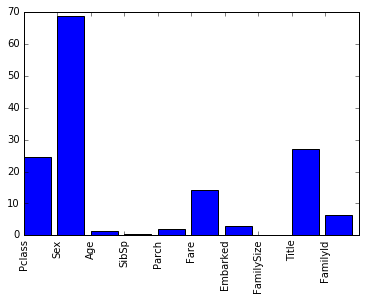

In [24]:
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [25]:
predictors = ["Pclass", "Sex", "Fare", "Title"]

In [26]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print(scores.mean())

0.811447811448


# final

In [27]:
titles = titanic_test["Name"].apply(get_title)

In [28]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles

In [29]:
print(pd.value_counts(titanic_test["Title"]))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [30]:
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"] + 1

In [31]:
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

In [36]:
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]],
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=8, min_samples_leaf=4), ["Pclass", "Sex", "Fare", "Title"]]
]

In [37]:
full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] + full_predictions[1]) / 2

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1

predictions = predictions.astype(int)

In [38]:
submission = pd.DataFrame({"PassengerId": titanic_test["PassengerId"], "Survived": predictions})

In [39]:
submission.to_csv("../submissions/Dataquest - Kaggle competitions - final.csv", index=False)

There's still more work you can do in feature engineering:

    Try using features related to the cabins.
    See if any family size features might help -- do the number of women in a family make the whole family more likely to survive?
    Does the national origin of the passenger's name have anything to do with survival?

There's also a lot more we can do on the algorithm side:

    Try the random forest classifier in the ensemble.
    A support vector machine might work well with this data.
    We could try neural networks.
    Boosting with a different base classifier might work better.

And with ensembling methods:

    Could majority voting be a better ensembling method than averaging probabilities?